# `StableSpectralElements.jl` - 2D isentropic vortex example

First, let's load the packages used in this example.

In [85]:
using StableSpectralElements, OrdinaryDiffEq
using Plots, Plots.PlotMeasures, TimerOutputs

We will be solving the two-dimensional compressible Euler equations with a specific heat ratio $\gamma = 1.4$ on a periodic domain of length $L=20$. The initial condition is taken to be the isentropic vortex used in the [Trixi.jl examples](https://github.com/trixi-framework/Trixi.jl/blob/main/examples/tree_2d_dgsem/elixir_euler_vortex.jl).

In [86]:
L = 20.0  # domain length
T = 20.0  # end time

conservation_law = EulerEquations{2}(1.4)
exact_solution = IsentropicVortex(conservation_law);

Let's discretize the above problem using a `NodalTensor` discretization of degree $p = 3$ on a Cartesian mesh with $M = 4$ edges in each direction. We will use collocated Legendre-Gauss-Lobatto (LGL) quadrature. A standard weak-form discontinuous Galerkin approach will be used, with a local Lax-Friedrichs numerical flux (the default option).

In [87]:
p = 3
M = 4

form = StandardForm()

reference_approximation = ReferenceApproximation(NodalTensor(p), Quad())

mesh = uniform_periodic_mesh(reference_approximation, ((-L/2, L/2),(-L/2, L/2)), (M,M))

spatial_discretization = SpatialDiscretization(mesh, reference_approximation)


results_path = save_project(conservation_law,
     spatial_discretization, exact_solution, form, (0.0, T),
    "results/euler_vortex_2d/", overwrite=true, clear=true);

ode = semidiscretize(conservation_law, spatial_discretization, 
    exact_solution, form, (0.0, T));

We'll now plot the mesh, showing the tensor-product quadrature nodes.

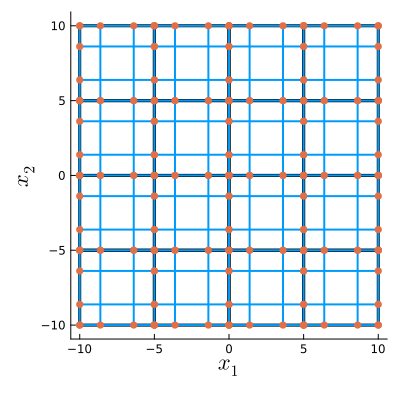

In [88]:
plot(spatial_discretization, grid_connect=true, fmt=:png)

The resulting system of ordinary differential equations can then be solved as usual using OrdinaryDiffEq.jl's `solve` function.

In [89]:
dt = T/1000
reset_timer!()
sol = solve(ode, CarpenterKennedy2N54(williamson_condition=false),
            dt=dt, adaptive=false, save_everystep=false, callback=save_callback(results_path, (0.0,T),  
        floor(Int, T/(dt*50))))
print_timer()

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            1.31s /  97.4%            904MiB /  99.7%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 du/dt                  5.05k    1.28s  100.0%   253μs    902MiB  100.0%   183KiB
   eval residual        5.05k    1.17s   91.2%   231μs    838MiB   93.0%   170KiB
   reconstruct noda...  5.05k    110ms    8.6%  21.8μs   63.4MiB    7.0%  12.8KiB
 ────────────────────────────────────────────────────────────────────────────────


The $L^2$ error in each variable (i.e. $\rho$, $\rho V_1$, $\rho V_2$, and $E$) can be computed as follows, where we have opted for an over-integrated quadrature rule.

In [90]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization, LGQuadrature(3*p))
println("L2 error:")
println(analyze(error_analysis, last(sol.u), exact_solution, T, normalize=true))

L2 error:
[0.0012392614076437835, 0.06951034921002601, 0.06930758075047193, 0.1374727707912807]


We'll finally check that the scheme is indeed conservative in all four variables.

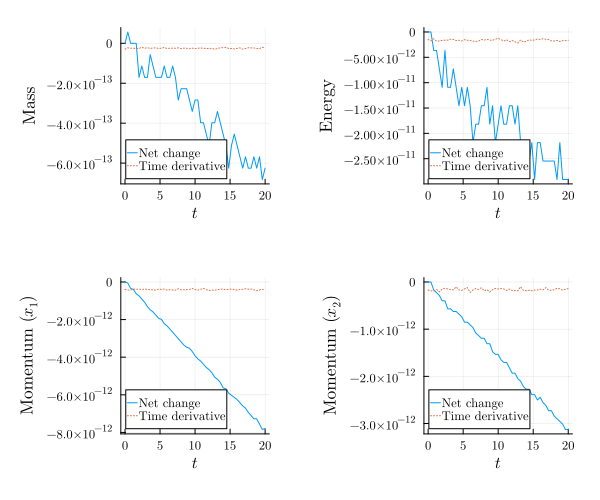

In [91]:
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
mass = plot(analyze(conservation_analysis, load_time_steps(results_path)), 
    ylabel="Mass", 1)
xmom = plot(analyze(conservation_analysis, load_time_steps(results_path)), 
    ylabel="Momentum (\$x_1\$)", 2)
ymom = plot(analyze(conservation_analysis, load_time_steps(results_path)), 
    ylabel="Momentum (\$x_2\$)", 3)
energy = plot(analyze(conservation_analysis, load_time_steps(results_path)), 
    ylabel="Energy", 4)

plot(mass, energy, xmom, ymom, size=(600,500), margin=5mm, fmt=:png)